In [1]:
#read AnandVihar_2018_2023.csv
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import matplotlib.dates as mdates
import seaborn as sns 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
sns.set(style="whitegrid")



In [2]:
def prepare_data(file_path):
    df = pd.read_csv(file_path)
    df['Time Stamp'] = pd.to_datetime(df['Time Stamp'])
    df_temp = df[['PM2.5', 'PM10', 'NO2', 'CO', 'Ozone', 'SO2']]
    corr_matrix = df_temp.corr()
    return corr_matrix


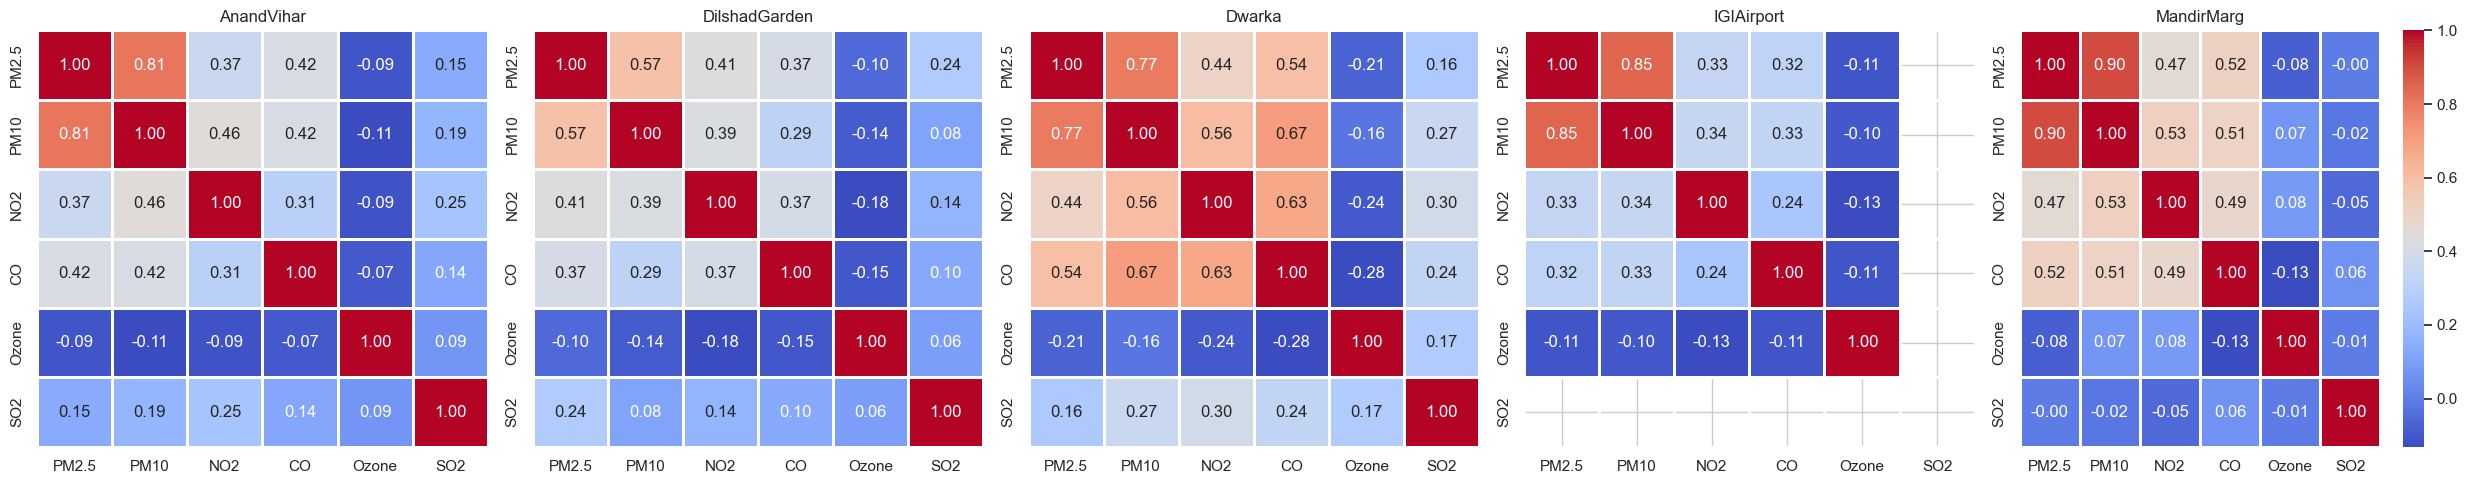

In [3]:
file_names = [
    'AnandVihar_2018_2023.csv',
    'DilshadGarden_2018_2023.csv',
    'Dwarka_2018_2023.csv',
    'IGIAirport_2018_2023.csv',
    'MandirMarg_2018_2023.csv'
]

# Initialize a large figure to hold all subplots
plt.figure(figsize=(25, 5))  # Adjust size as needed to fit all subplots side by side

# Loop through files and plot each in a subplot
for i, file_name in enumerate(file_names, 1):
    corr_matrix = prepare_data(file_name)
    ax = plt.subplot(1, 5, i)  # 1 row, 5 columns, ith subplot
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=i==len(file_names), linewidths=.9)
    ax.set_title(file_name.split('_')[0])

plt.tight_layout()
plt.show()


### By observing the output we understand that there is a strong relation between PM2.5 and PM10 and less connected with CO or NO2, while very weak relation with ozone and SO2

In [4]:
def prepare_and_plot_pm25(file_path, ax):
    # Read and prepare the data
    df = pd.read_csv(file_path)
    df['Time Stamp'] = pd.to_datetime(df['Time Stamp'])
    df_temp = df[['Time Stamp', 'PM2.5']].set_index('Time Stamp').resample('D').mean().reset_index()
    
    # Convert 'Time Stamp' to matplotlib dates
    df_temp['Time Stamp'] = mdates.date2num(df_temp['Time Stamp'])
    
    # Plot heatmap
    cax = ax.imshow([df_temp['PM2.5'].values], aspect='auto', cmap='hot',
                    extent=[df_temp['Time Stamp'].iloc[0], df_temp['Time Stamp'].iloc[-1], 0, 1])
    ax.xaxis_date()
    ax.set_title(file_path.split('/')[-1])
    return cax

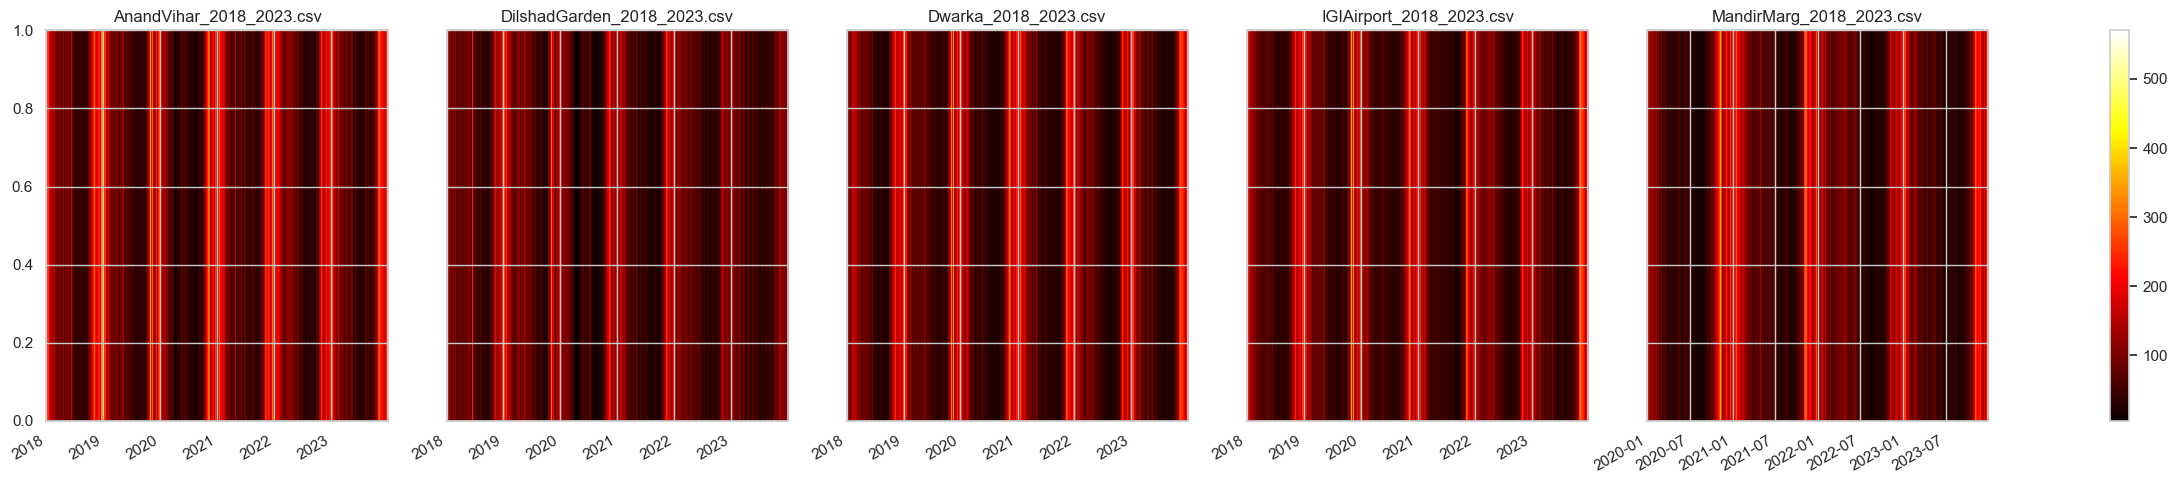

In [5]:
file_names = [
    'AnandVihar_2018_2023.csv',
    'DilshadGarden_2018_2023.csv',
    'Dwarka_2018_2023.csv',
    'IGIAirport_2018_2023.csv',
    'MandirMarg_2018_2023.csv'
]

# Setup the figure and subplots
fig, axes = plt.subplots(1, 5, figsize=(25, 5), sharey=True)  # Adjust size as needed

# Process each file and create its subplot
for ax, file_name in zip(axes, file_names):
    cax = prepare_and_plot_pm25(file_name, ax)

# Formatting the overall figure
fig.autofmt_xdate()
fig.tight_layout()
fig.colorbar(cax, ax=axes.ravel().tolist(), orientation='vertical')  # Add one colorbar for all
plt.show()

## We can observe the heatmap for PM2.5 where the heat is more darker in the winter and this is general trend for the past 6 years

In [6]:
def load_and_prepare_data(file_name):
    df = pd.read_csv(file_name)
    df['Time Stamp'] = pd.to_datetime(df['Time Stamp'])
    df.set_index('Time Stamp', inplace=True)  # Set 'Time Stamp' as index for resampling
    df = df.resample('D').mean()  # Resample daily and compute the mean
    df.reset_index(inplace=True)  # Reset the index to bring 'Time Stamp' back as a column
    
    return df


In [7]:
def plot_time_series_side_by_side(dataframes, columns, titles):
    n = len(dataframes)
    fig, axes = plt.subplots(1, n, figsize=(20, 5), sharey=True)  # Adjust figsize as needed

    for ax, (title, df) in zip(axes, dataframes.items()):
        for column in columns:
            ax.plot(df['Time Stamp'], df[column], label=column)
        ax.set_title(title)
        ax.set_xlabel('Date')
        ax.set_ylabel('Concentration')
        ax.legend()

    plt.tight_layout()
    plt.show()


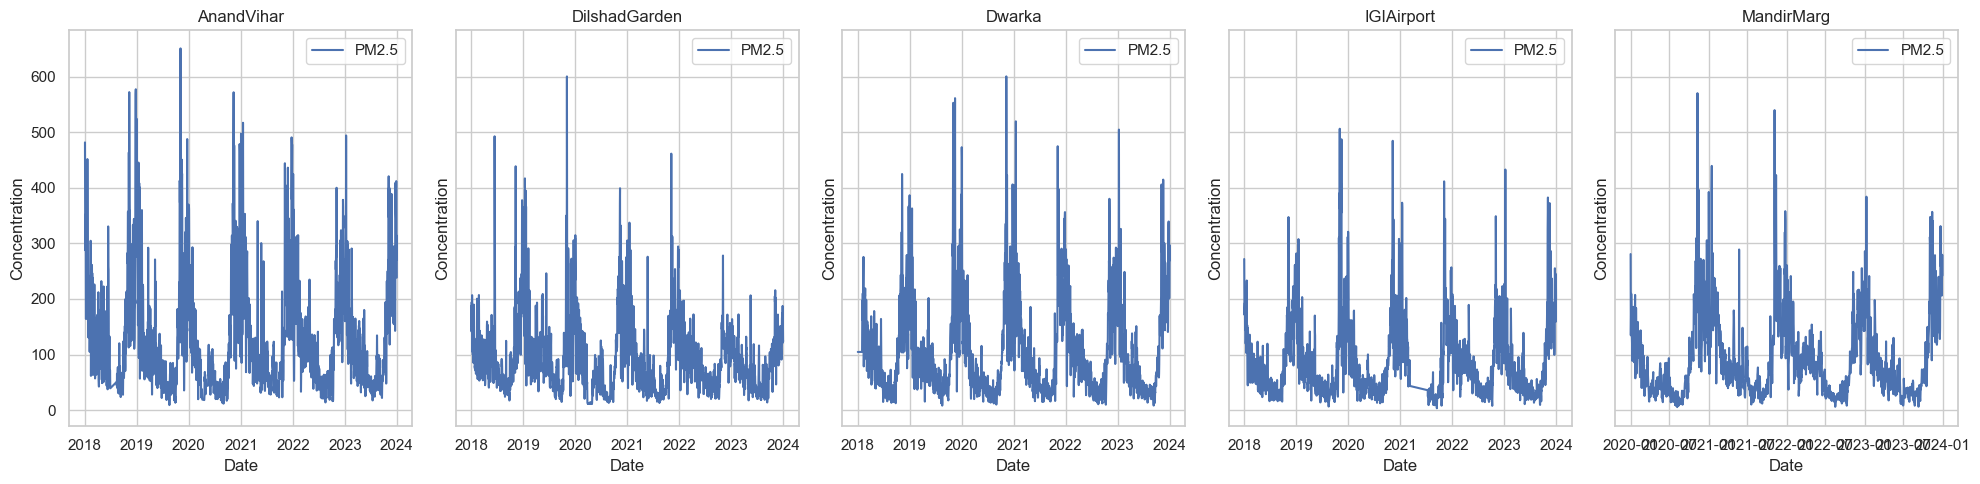

In [8]:
file_names = [
    'AnandVihar_2018_2023.csv',
    'DilshadGarden_2018_2023.csv',
    'Dwarka_2018_2023.csv',
    'IGIAirport_2018_2023.csv',
    'MandirMarg_2018_2023.csv'
]

dataframes = {}
titles = []

for file_name in file_names:
    df = load_and_prepare_data(file_name)  # Ensure to use the correct function
    key = file_name.split('_')[0]
    dataframes[key] = df
    titles.append(key)

# Plotting side by side time series for PM2.5
plot_time_series_side_by_side(dataframes, ['PM2.5'], titles)


## Let us see for PM2.5 trends over years and in different places

In [9]:
def load_data(file_name):
    df = pd.read_csv(file_name, parse_dates=['Time Stamp'])
    df.set_index('Time Stamp', inplace=True)
    return df


In [10]:
def aggregate_pollutant(df, pollutant, freq='Y'):
    """Resample and average data for a given pollutant based on frequency."""
    if pollutant in df.columns:
        aggregated = df[pollutant].resample(freq).mean()
        return aggregated
    else:
        print(f"{pollutant} not found in dataframe.")
        return None


In [11]:
def plot_trends_side_by_side(dataframes, titles, pollutants, freq='Y'):
    num_datasets = len(dataframes)
    num_pollutants = len(pollutants)

    # Create a subplot grid with one row per pollutant and one column per dataset
    fig, axes = plt.subplots(num_pollutants, num_datasets, figsize=(5 * num_datasets, 4 * num_pollutants), sharex='col', sharey='row')

    for i, pollutant in enumerate(pollutants):
        for j, (title, df) in enumerate(zip(titles, dataframes)):
            ax = axes[i][j] if num_pollutants > 1 else axes[j]
            aggregated_data = aggregate_pollutant(df, pollutant, freq)
            if aggregated_data is not None:
                ax.plot(aggregated_data.index, aggregated_data.values)
                ax.set_title(f'{pollutant} in {title}')
                ax.set_xlabel('Year' if freq == 'Y' else 'Time')
                if j == 0:
                    ax.set_ylabel('Avg Concentration')
                if i == num_pollutants - 1:
                    ax.set_xlabel('Year' if freq == 'Y' else 'Time')

    # Improve subplot spacing and adjust subplots
    plt.subplots_adjust(hspace=0.5, wspace=0.3)  # Adjust horizontal and vertical spacing
    plt.tight_layout()
    plt.show()


C:\Users\jetha\AppData\Local\Temp\ipykernel_38808\65697643.py:4: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  aggregated = df[pollutant].resample(freq).mean()


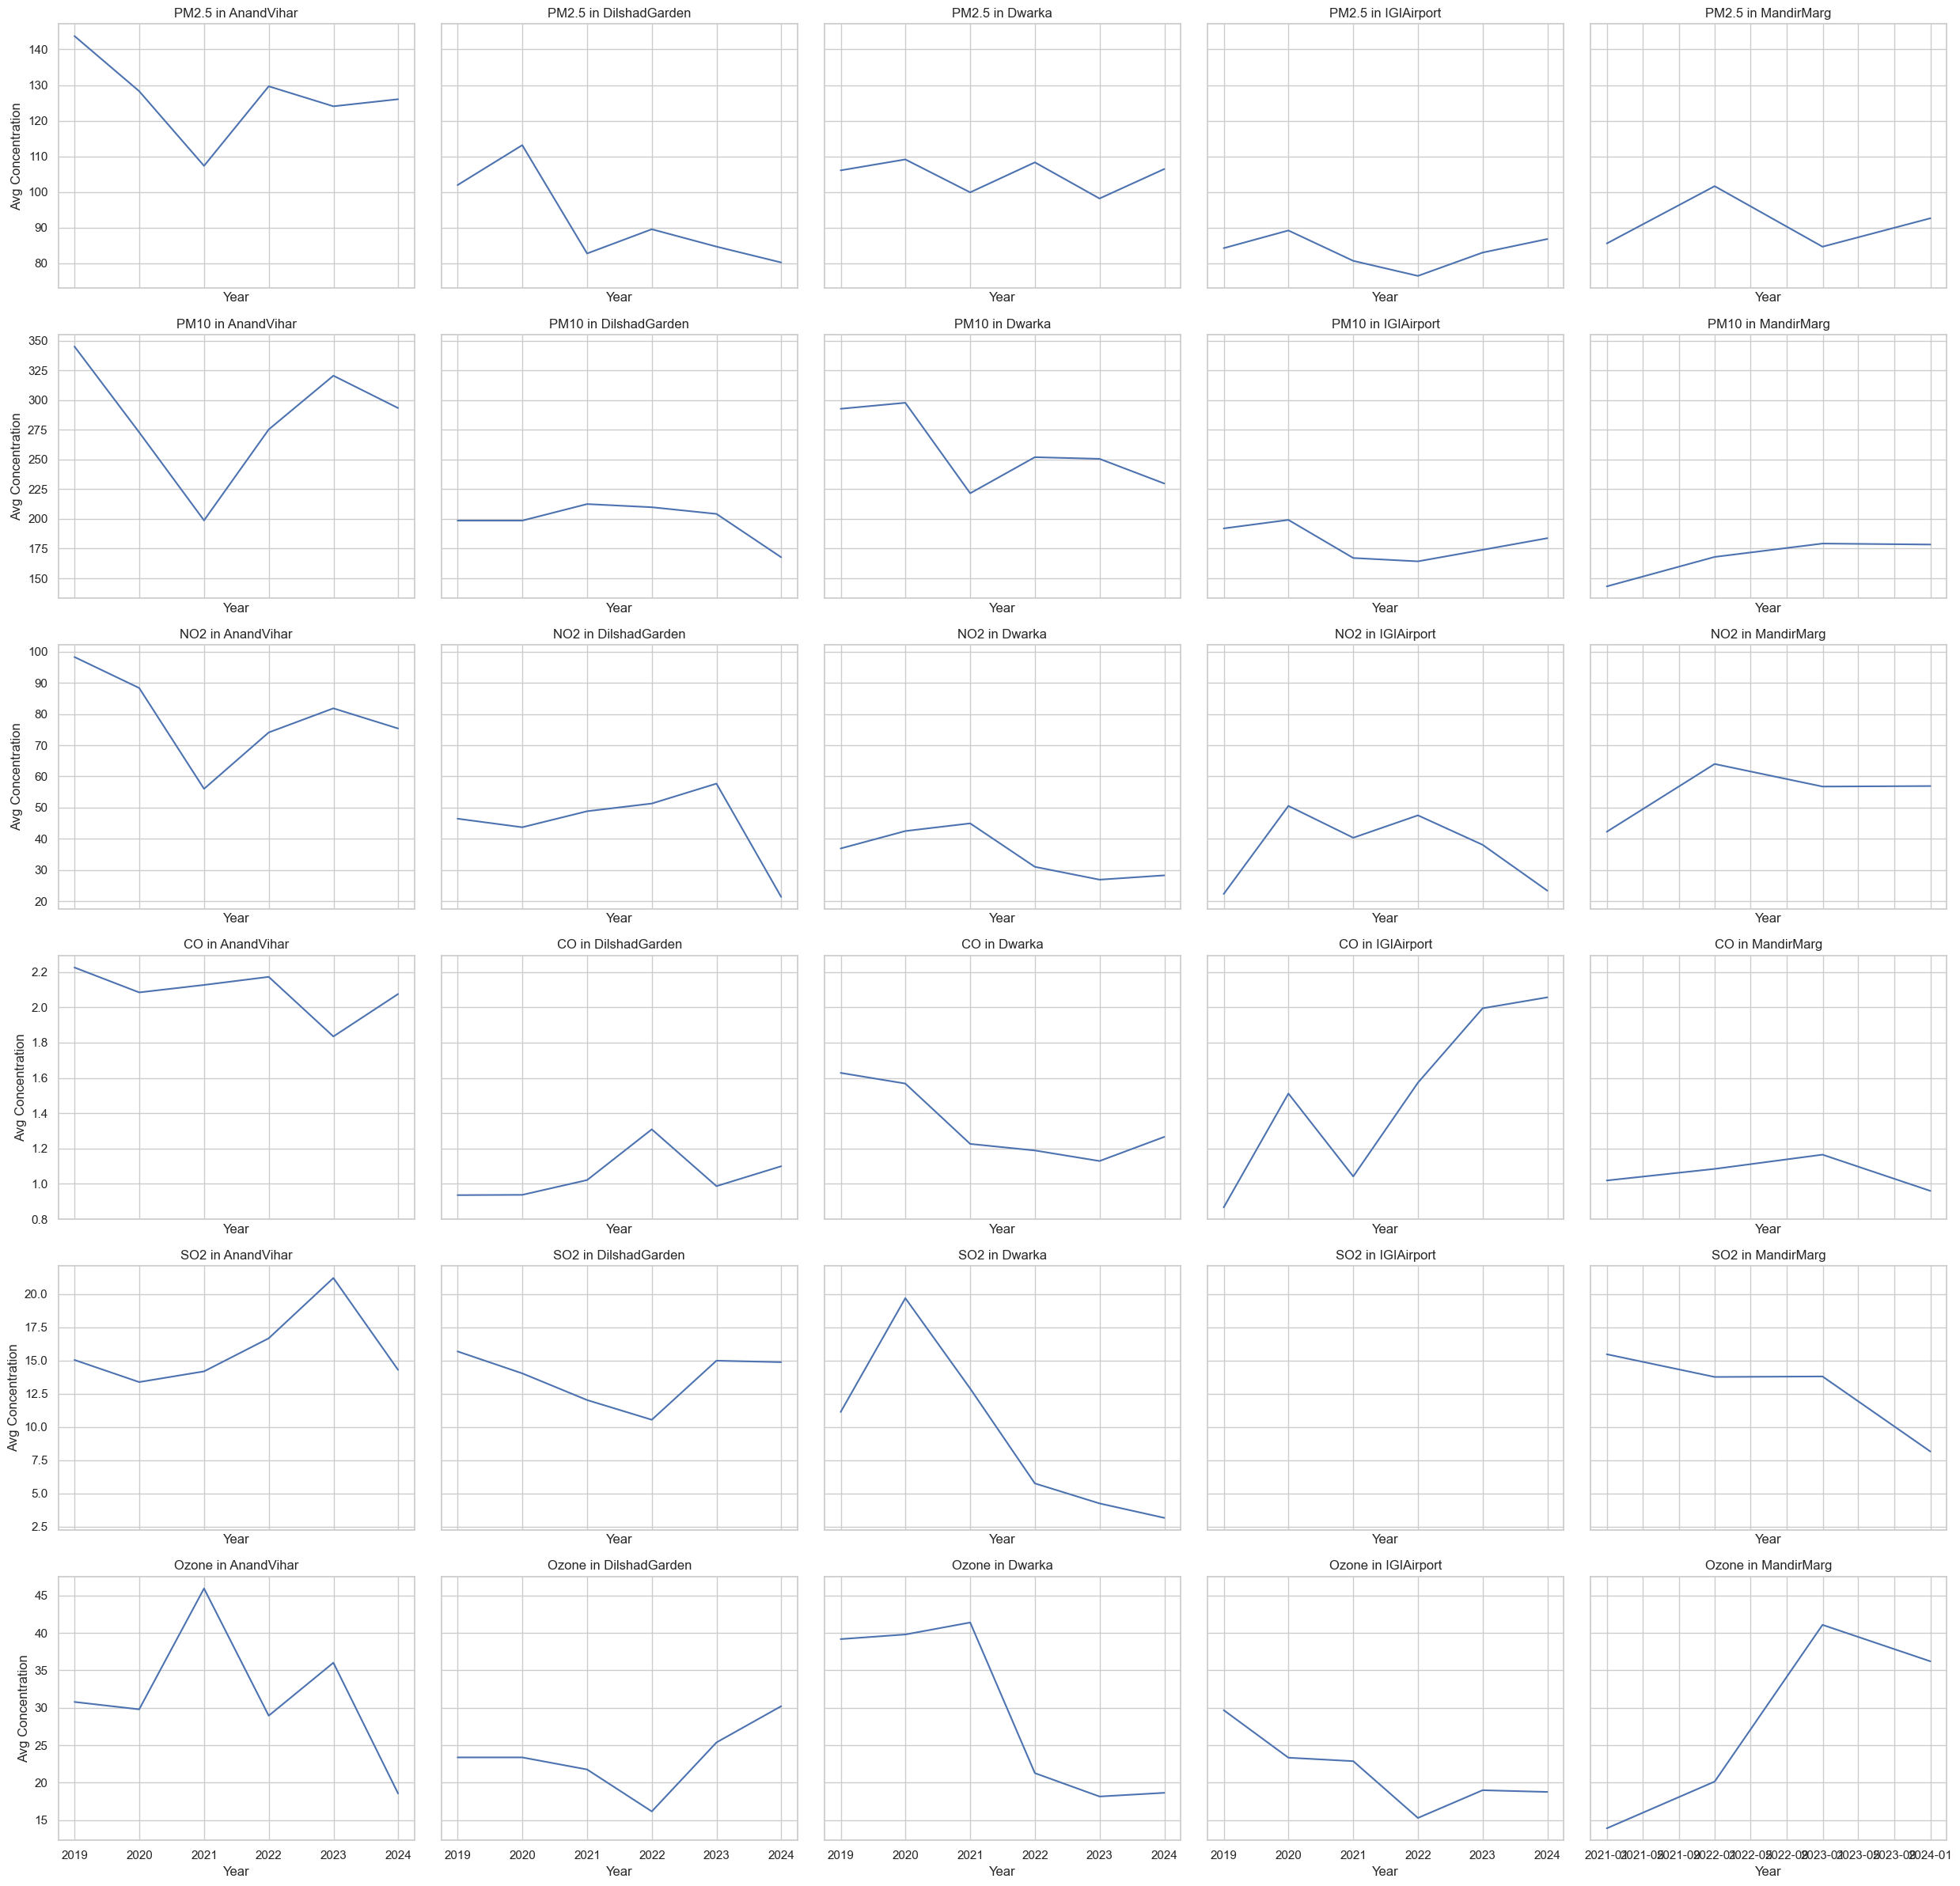

In [12]:
file_names = [
    'AnandVihar_2018_2023.csv',
    'DilshadGarden_2018_2023.csv',
    'Dwarka_2018_2023.csv',
    'IGIAirport_2018_2023.csv',
    'MandirMarg_2018_2023.csv'
]

pollutants = ['PM2.5', 'PM10', 'NO2', 'CO', 'SO2', 'Ozone']
dataframes = []
titles = []

for file_name in file_names:
    df = load_data(file_name)
    dataframes.append(df)
    titles.append(file_name.split('_')[0])

plot_trends_side_by_side(dataframes, titles, pollutants)


In [14]:
import csv

def read_filtered_data(filename):
    data = []
    with open(filename, 'r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            data.append({
                'PM2.5': row['PM2.5'],
                'PM10': row['PM10'],
                'NO2': row['NO2'],
                'SO2': row['SO2'],
                'CO': row['CO'],
                'Ozone': row['Ozone'],
            })
    return data

filtered_data = read_filtered_data('AnandVihar_2018_2023.csv')
# len(filtered_data)
filtered_data



[{'PM2.5': '754.0',
  'PM10': '',
  'NO2': '127.13',
  'SO2': '19.75',
  'CO': '7.77',
  'Ozone': '24.91'},
 {'PM2.5': '754.0',
  'PM10': '',
  'NO2': '87.39',
  'SO2': '14.6',
  'CO': '7.98',
  'Ozone': '26.59'},
 {'PM2.5': '868.0',
  'PM10': '',
  'NO2': '69.39',
  'SO2': '14.25',
  'CO': '7.09',
  'Ozone': '18.79'},
 {'PM2.5': '854.0',
  'PM10': '',
  'NO2': '48.4',
  'SO2': '10.3',
  'CO': '2.43',
  'Ozone': '14.24'},
 {'PM2.5': '713.0',
  'PM10': '917.0',
  'NO2': '46.4',
  'SO2': '10.13',
  'CO': '1.62',
  'Ozone': '14.59'},
 {'PM2.5': '625.0',
  'PM10': '802.0',
  'NO2': '63.01',
  'SO2': '7.64',
  'CO': '0.32',
  'Ozone': '32.17'},
 {'PM2.5': '275.0',
  'PM10': '407.0',
  'NO2': '63.47',
  'SO2': '18.02',
  'CO': '0.12',
  'Ozone': '16.56'},
 {'PM2.5': '236.0',
  'PM10': '333.0',
  'NO2': '66.06',
  'SO2': '20.81',
  'CO': '0.6',
  'Ozone': '14.06'},
 {'PM2.5': '229.0',
  'PM10': '322.0',
  'NO2': '67.18',
  'SO2': '20.93',
  'CO': '0.2',
  'Ozone': '13.67'},
 {'PM2.5': '252.0'

## Referring to https://pib.gov.in/newsite/printrelease.aspx?relid=110654 for PM2.5, PM10, NO2, SO2, CO, ozone

### I = [(IHI - ILO) / (BPHI - BPLO)] * (C - BPLO) + ILO formula AQI subindex

## Identifying BPHI and BPLO for each parameter

In [16]:
df_new=pd.read_csv('AnandVihar_2018_2023.csv')

max_values = df_new.max()
min_values = df_new.min()

pm25_max = max_values['PM2.5']
pm25_min = min_values['PM2.5']
pm10_max = max_values['PM10']
pm10_min = min_values['PM10']
no2_max = max_values['NO2']
no2_min = min_values['NO2']
so2_max = max_values['SO2']
so2_min = min_values['SO2']
co_max = max_values['CO']
co_min = min_values['CO']
ozone_max = max_values['Ozone']
ozone_min = min_values['Ozone']


In [18]:
print('PM2.5 Max:', pm25_max, 'PM2.5 Min:', pm25_min, 'PM10 Max:', pm10_max, 'PM10 Min:', pm10_min, 'NO2 Max:', no2_max, 'NO2 Min:', no2_min, 'SO2 Max:', so2_max, 'SO2 Min:', so2_min, 'CO Max:', co_max, 'CO Min:', co_min, 'Ozone Max:', ozone_max, 'Ozone Min:', ozone_min)

PM2.5 Max: 985.0 PM2.5 Min: 0.2 PM10 Max: 1000.0 PM10 Min: 1.0 NO2 Max: 499.2 NO2 Min: 0.1 SO2 Max: 193.6 SO2 Min: 0.1 CO Max: 19.7 CO Min: 0.0 Ozone Max: 199.5 Ozone Min: 0.1


In [19]:
average_pm25 = df_new['PM2.5'].mean()
average_pm10 = df_new['PM10'].mean()
average_no2 = df_new['NO2'].mean()
average_so2 = df_new['SO2'].mean()

In [27]:
df_new['Time Stamp'] = pd.to_datetime(df_new['Time Stamp'])
ozone_8hr_avg = df_new.set_index('Time Stamp').resample('8H')['Ozone'].mean().reset_index()
print(ozone_8hr_avg)

#take absoulte average 
average_ozone = ozone_8hr_avg['Ozone'].mean()
average_ozone



              Time Stamp      Ozone
0    2018-01-01 00:00:00  20.238750
1    2018-01-01 08:00:00  29.498750
2    2018-01-01 16:00:00  33.373750
3    2018-01-02 00:00:00  24.176250
4    2018-01-02 08:00:00  31.088750
...                  ...        ...
6568 2023-12-30 08:00:00  26.678125
6569 2023-12-30 16:00:00  18.987500
6570 2023-12-31 00:00:00  25.315625
6571 2023-12-31 08:00:00  19.221875
6572 2023-12-31 16:00:00  17.979167

[6573 rows x 2 columns]


C:\Users\jetha\AppData\Local\Temp\ipykernel_38808\2998015554.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ozone_8hr_avg = df_new.set_index('Time Stamp').resample('8H')['Ozone'].mean().reset_index()


31.6732451252599

In [28]:
df_new['Time Stamp'] = pd.to_datetime(df_new['Time Stamp'])
co_8hr_avg = df_new.set_index('Time Stamp').resample('8H')['CO'].mean().reset_index()
print(co_8hr_avg)

#take absoulte average
average_co = co_8hr_avg['CO'].mean()
average_co

              Time Stamp        CO
0    2018-01-01 00:00:00  3.491250
1    2018-01-01 08:00:00  2.388750
2    2018-01-01 16:00:00  4.156250
3    2018-01-02 00:00:00  5.493750
4    2018-01-02 08:00:00  2.683750
...                  ...       ...
6568 2023-12-30 08:00:00  2.246250
6569 2023-12-30 16:00:00  2.209062
6570 2023-12-31 00:00:00  1.905625
6571 2023-12-31 08:00:00  2.104062
6572 2023-12-31 16:00:00  1.750417

[6573 rows x 2 columns]


C:\Users\jetha\AppData\Local\Temp\ipykernel_38808\1038303304.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  co_8hr_avg = df_new.set_index('Time Stamp').resample('8H')['CO'].mean().reset_index()


2.086295514478422

In [22]:
print("Avg PM2.5: ", average_pm25,"Avg PM10: ", average_pm10,"Avg NO2: ", average_no2,"Avg SO2: ", average_so2)

Avg PM2.5:  126.5083254095035 Avg PM10:  284.31367734880183 Avg NO2:  78.98592891056849 Avg SO2:  15.793432809092751


In [31]:
def calculate_subindex(pollutant_data):
    """Calculates the AQI sub-index for a given pollutant.

    Args:
        pollutant_data: A dictionary containing the pollutant's concentration (C),
                        breakpoint values (BPHI, BPLO), and index limits (IHI, ILo).

    Returns:
        The calculated AQI sub-index.
    """

    C = pollutant_data["C"]
    BPHI = pollutant_data["BPHI"]
    BPLO = pollutant_data["BPLO"]
    IHi = pollutant_data["IHi"]
    ILo = pollutant_data["ILo"]

    # Use the AQI formula 
    subindex = ((IHi - ILo) / (BPHI - BPLO)) * (C - BPLO) + ILo

    return round(subindex, 2)  # Round to two decimal places

# Your manually observed data
data = {
    "PM2.5": {
        "C": int(average_pm25),
        "IHi": 400,
        "ILo": 301,
        "BPHI": 250,
        "BPLO": 121
    },
    "PM10": {
        "C": int(average_pm10),
        "IHi": 300,
        "ILo": 201,
        "BPHI": 350,
        "BPLO": 251
    },
    "NO2": {
        "C": int(average_no2),
        "IHi": 100,
        "ILo": 51,
        "BPHI": 80,
        "BPLO": 41
    },
    "SO2": {
        "C":int( average_so2),
        "IHi": 50,
        "ILo": 0,
        "BPHI": 40,
        "BPLO": 0
    },
    "CO": {
        "C": int(average_co),  # Assuming overall average
        "IHi": 200,
        "ILo": 101,
        "BPHI": 10,
        "BPLO": 2.1
    },
    "O3": {
        "C": int(average_ozone),  # Assuming overall average
        "IHi": 50,
        "ILo": 0,
        "BPHI": 50,
        "BPLO": 0
    },
    
}

# Calculate and print the sub-indexes
for pollutant, pollutant_data in data.items():
    subindex = calculate_subindex(pollutant_data)
    print(f"{pollutant}: {subindex}")


PM2.5: 304.84
PM10: 234.0
NO2: 97.49
SO2: 18.75
CO: 99.75
O3: 31.0


## Average AQI for all the years combined is 304.84 (highest subindex is declared the AQI)

In [2]:
import pandas as pd

def calculate_aqi_row(C, BPLO, BPHI, ILO, IHI):
    """Calculate AQI for a single row given pollutant concentration and AQI breakpoints."""
    try:
        if C < BPLO:
            return ILO
        elif C > BPHI:
            return IHI
        else:
            return ((IHI - ILO) / (BPHI - BPLO)) * (C - BPLO) + ILO
    except:
        return None

# Define AQI breakpoints as dictionaries for easier access
aqi_breakpoints = {
    'PM2.5': {'BPLO': 121, 'BPHI': 250, 'ILO': 301, 'IHI': 400},
    'PM10': {'BPLO': 250, 'BPHI': 350, 'ILO': 201, 'IHI': 300},
    'NO2': {'BPLO': 41, 'BPHI': 80, 'ILO': 51, 'IHI': 100},
    'SO2': {'BPLO': 0, 'BPHI': 40, 'ILO': 0, 'IHI': 50},
    'CO': {'BPLO': 2.1, 'BPHI': 10, 'ILO': 101, 'IHI': 200},
    'Ozone': {'BPLO': 0, 'BPHI': 50, 'ILO': 0, 'IHI': 50}
}


In [9]:
# Load the data
df = pd.read_csv(r'C:\Aditya\Python\Khushi Project\MandirMarg_2018_2023.csv')
df['Time Stamp'] = pd.to_datetime(df['Time Stamp'])

# Calculate AQI for each pollutant
for pollutant in aqi_breakpoints:
    bp = aqi_breakpoints[pollutant]
    df[f'{pollutant} Subindex'] = df[pollutant].apply(lambda x: calculate_aqi_row(x, bp['BPLO'], bp['BPHI'], bp['ILO'], bp['IHI']))

# Display the updated DataFrame
# print(df)

df.to_csv('MandirMarg_AQI_2018_2023.csv', index=False)


In [10]:
import pandas as pd

# Assume df is already loaded and AQI subindices are calculated
# For the sake of completeness, let's assume you have these columns in df:
# 'PM2.5 AQI', 'PM10 AQI', 'NO2 AQI', 'SO2 AQI', 'CO AQI', 'O3 AQI'

# Define pollutants for which AQI has been calculated
pollutants = ['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'Ozone']

# Calculate the overall AQI by taking the maximum of the AQI subindices for each row
df['Overall AQI'] = df[[f"{p} Subindex" for p in pollutants]].max(axis=1)

# Display the updated DataFrame
# print(df.head())

df.to_csv('MandirMarg_AQI_2018_2023.csv', index=False)
